In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import os, sys
import toml
config = toml.load('../../../../configuration/input_configuration.toml')
%matplotlib inline

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# % Tours by Destination District
# % Trips by Desitnation District
# % People by District

In [2]:
working_dir = r'../../../../outputs/agg/dash'
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

In [3]:
def load_data(fname):
    """ open and join model and survey data """

    df_model = pd.read_csv(os.path.join(working_dir,fname+'.csv'))
    df_model['source'] = 'model'
    df_survey = pd.read_csv(os.path.join(working_dir,'survey',fname+'.csv'))
    df_survey['source'] = 'survey'
    df = df_model.append(df_survey)

    return df

In [4]:
df = load_data('trip_total')

In [5]:
parcel_geog = pd.read_sql_table('parcel_'+config['base_year']+'_geography', 'sqlite:///../../../../inputs/db/'+config['db_name'],
        columns=['District','ParcelID'])

In [6]:
district_lookup = {1: 'Suburban Snohomish',
                  2: 'Everett-Lynwood-Edmonds',
                  3: 'North Seattle-Shoreline',
                  4: 'Seattle CBD',
                  5: 'West-South Seattle',
                  6: 'East Side',
                   7: 'Renton-FedWay-Kent',
                   8: 'Tacoma',
                   9: 'Kitsap',
                   10: 'South Pierce',
                   11: 'S.Kitsap'
                  }

# Average Distance by Tour Purpose

source,model,survey
pdpurp,,
Escort,4.37,5.33
Meal,3.35,3.16
Personal Business,6.07,6.16
School,5.28,4.37
Shop,4.75,4.13
Social,6.03,5.75
Work,11.47,11.34


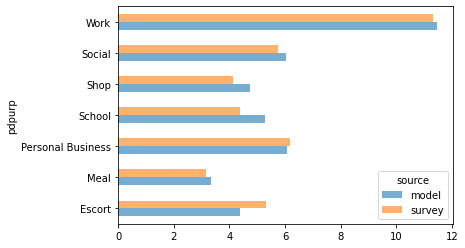

In [7]:
df = load_data('tour_distance')
# Trim any unreasonable survey distances off by taking max distance as max modeled bin value
max_model_dist = df.loc[(df['source']=='model'), 'tautodist_bin'].max()
df = df.loc[df['tautodist_bin'] <= max_model_dist]
df['wt_autodist'] = (df['tautodist_bin']+0.5)*(df['toexpfac'])
df_dist = pd.DataFrame()
for source in ['model','survey']:
    _df = df[(df['source'] == source)]
    df1 = _df.groupby('pdpurp').sum()[['wt_autodist']].reset_index()
    df2 = _df.groupby('pdpurp').sum()[['toexpfac']].reset_index ()
    _df = df1.merge(df2, on='pdpurp')
    _df['commute_distance'] = _df['wt_autodist']/_df['toexpfac']
    _df['source'] = source
    df_dist = df_dist.append(_df)
df = df_dist.pivot_table(index='pdpurp', columns='source', aggfunc='first', values='commute_distance')
df.rename(columns={'pdpurp': 'Tour Purpose'}, inplace=True)
# df.drop('Change Mode Inserted Purpose', axis=0, inplace=True)
df.plot(kind='barh', alpha=0.6)
df

# Average Distance by Tour Mode

source,model,survey
tmodetp,,
Bike,3.93,1.93
HOV2,6.97,6.82
HOV3+,6.93,7.32
SOV,8.64,8.29
School Bus,5.72,3.70
TNC,5.79,6.13
Transit,7.42,7.89
Walk,1.09,0.85


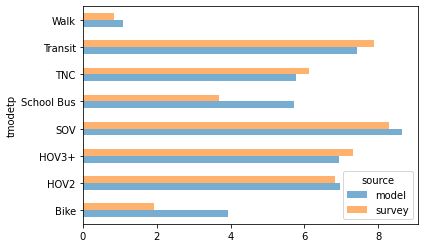

In [8]:
df = load_data('tour_distance')
# Trim any unreasonable survey distances off by taking max distance as max modeled bin value
max_model_dist = df.loc[(df['source']=='model'), 'tautodist_bin'].max()
df = df.loc[df['tautodist_bin'] <= max_model_dist]
df['wt_autodist'] = (df['tautodist_bin']+0.5)*(df['toexpfac'])
df_dist = pd.DataFrame()
for source in ['model','survey']:
    _df = df[(df['source'] == source)]
    df1 = _df.groupby('tmodetp').sum()[['wt_autodist']].reset_index()
    df2 = _df.groupby('tmodetp').sum()[['toexpfac']].reset_index ()
    _df = df1.merge(df2, on='tmodetp')
    _df['commute_distance'] = _df['wt_autodist']/_df['toexpfac']
    _df['source'] = source
    df_dist = df_dist.append(_df)
df = df_dist.pivot_table(index='tmodetp', columns='source', aggfunc='first', values='commute_distance')
df.rename(columns={'tmodetp': 'Tour Mode'}, inplace=True)

df.drop('Park', inplace=True)
df.plot(kind='barh', alpha=0.6)
df

# Trips per Tour by Tour Purpose
Average number of trip legs in a tour

source,model,survey
pdpurp,,
Escort,2.67,2.56
Meal,2.57,2.70
Personal Business,2.50,2.88
School,2.89,2.39
Shop,2.67,2.81
Social,2.42,2.67
Work,3.40,2.99


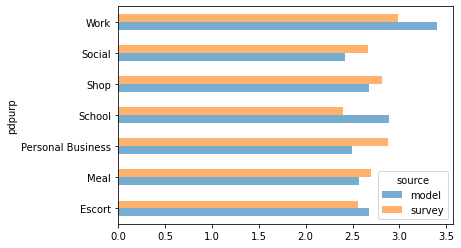

In [9]:
df = load_data('trips_by_tour')
df['wt_tot_trips'] = (df['tripsh1']+df['tripsh2'])*df['toexpfac']

df1 = df.pivot_table(columns='source', index='pdpurp', values='toexpfac', aggfunc='sum')
df2 = df.pivot_table(columns='source', index='pdpurp', values='wt_tot_trips', aggfunc='sum')

df = df2/df1
# df.drop('Change Mode Inserted Purpose', axis=0, inplace=True)
df.plot(kind='barh', alpha=0.6)
df

# Trips per Tour by Tour Mode
Average number of trip legs in a tour

source,model,survey
tmodetp,,
Bike,2.55,2.46
HOV2,2.93,2.86
HOV3+,2.98,3.06
SOV,2.76,2.76
School Bus,2.56,2.18
TNC,2.95,2.62
Transit,2.72,2.48
Walk,2.45,2.20


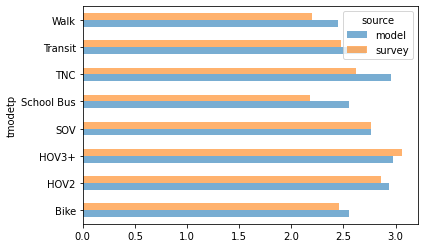

In [10]:
df = load_data('trips_by_tour')
df['wt_tot_trips'] = (df['tripsh1']+df['tripsh2'])*df['toexpfac']

df1 = df.pivot_table(columns='source', index='tmodetp', values='toexpfac', aggfunc='sum')
df2 = df.pivot_table(columns='source', index='tmodetp', values='wt_tot_trips', aggfunc='sum')

df = df2/df1
df.drop('Park', axis=0, inplace=True)
df.plot(kind='barh', alpha=0.6)
df

# Tour Destinations by District
Total tours with primary destinations in each district

,model,survey
Suburban Snohomish,11.31%,13.97%
Everett-Lynwood-Edmonds,8.25%,4.74%
North Seattle-Shoreline,6.98%,8.50%
Seattle CBD,10.73%,4.21%
West-South Seattle,5.81%,6.15%
East Side,15.48%,18.01%
Renton-FedWay-Kent,15.00%,18.32%
Tacoma,7.13%,3.22%
Kitsap,5.94%,6.45%
South Pierce,11.95%,13.32%


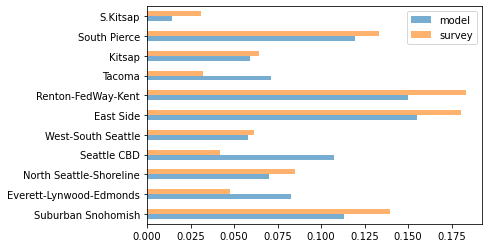

In [11]:
pd.options.display.float_format = '{:0,.2%}'.format

_df = pd.DataFrame()
for id, name in district_lookup.items():
    df = load_data('tour_total_tour_d_district_'+name)
    for source in ['model','survey']:
        _df.loc[name,source] = df[df['source'] == source]['toexpfac'].sum()
        
_df = _df/_df.sum()
_df.plot(kind='barh', alpha=0.6)
_df